In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
#from sklearn.base import BaseEstimator, RegressorMixin
#from sklearn.model_selection import GridSearchCV

#from FFN_class_importable import FFN
#from Gillespie_method import gillespie

In [4]:
# Gillespie function
def gillespie(initial_states, transcription_rate, basal_transcript_rate, mRNA_degradation_rate, translation_rate, protein_degradation_rate, n, max_time):
    t = 0
    state = np.array(initial_states)
    times = [t]
    states = [state.copy()]

    while t < max_time:
        TetR_mRNA, TetR_protein, cI_mRNA, cI_protein, LacI_mRNA, LacI_protein = state

        # Propensities
        a = np.array([
            (transcription_rate / (1 + LacI_protein ** n)) + basal_transcript_rate,  # production of TetR_mRNA
            mRNA_degradation_rate * TetR_mRNA,  # degradation of TetR_mRNA
            translation_rate * TetR_mRNA,  # production of TetR protein
            protein_degradation_rate * TetR_protein,  # degradation of TetR protein

            (transcription_rate / (1 + TetR_protein ** n)) + basal_transcript_rate,  # production of cI_mRNA
            mRNA_degradation_rate * cI_mRNA,  # degradation of cI_mRNA
            translation_rate * cI_mRNA,  # production of cI protein
            protein_degradation_rate * cI_protein,  # degradation of cI protein

            (transcription_rate / (1 + cI_protein ** n)) + basal_transcript_rate,  # production of LacI_mRNA
            mRNA_degradation_rate * LacI_mRNA,  # degradation of LacI_mRNA
            translation_rate * LacI_mRNA,  # production of LacI protein
            protein_degradation_rate * LacI_protein  # degradation of LacI protein
        ])

        a0 = np.sum(a)
        if a0 == 0:
            break

        r1 = np.random.random()
        tau = (1 / a0) * np.log(1 / r1)

        r2 = np.random.uniform(0, 1)
        cumulative_sum = np.cumsum(a)
        reaction_index = np.searchsorted(cumulative_sum, r2 * a0)

        # Update the system
        state_changes = [
            [1, 0, 0, 0, 0, 0],   # mRNA_TetR production
            [-1, 0, 0, 0, 0, 0],  # mRNA_TetR degradation
            [0, 1, 0, 0, 0, 0],   # protein_TetR production
            [0, -1, 0, 0, 0, 0],  # protein_TetR degradation

            [0, 0, 1, 0, 0, 0],   # mRNA_cI production
            [0, 0, -1, 0, 0, 0],  # mRNA_cI degradation
            [0, 0, 0, 1, 0, 0],   # protein_cI production
            [0, 0, 0, -1, 0, 0],  # protein_cI degradation

            [0, 0, 0, 0, 1, 0],   # mRNA_LacI production
            [0, 0, 0, 0, -1, 0],  # mRNA_LacI degradation
            [0, 0, 0, 0, 0, 1],   # protein_LacI production
            [0, 0, 0, 0, 0, -1],  # protein_LacI degradation
        ]

        state += state_changes[reaction_index]
        t += tau

        times.append(t)
        states.append(state.copy())

    return np.array(times), np.array(states)
    

In [5]:
### start by developing your data set, this is the trial for one run
initial_states = [0, 3, 0, 0, 0, 0]
# initial states structure is mRNA_TetR, protein_TetR, mRNA_cI, protein_cI, mRNA_LacI, protein_LacI

# Parameters (example values, adjust as necessary)
transcription_rate = 50
basal_transcript_rate = 0.01
mRNA_degradation_rate = 1
translation_rate = 5
protein_degradation_rate = 2
n = 2  # Hill coefficient
max_time = 100

# Run the simulation
times, states = gillespie(initial_states, transcription_rate, basal_transcript_rate, mRNA_degradation_rate, translation_rate, protein_degradation_rate, n, max_time)

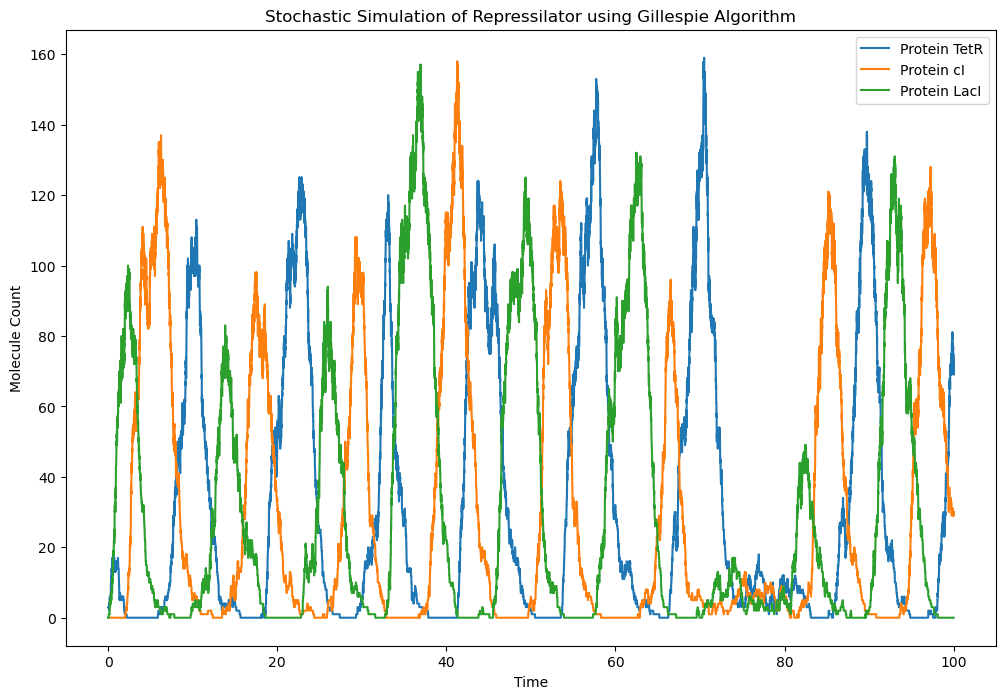

In [6]:
mRNA_TetR = states[:, 0]
protein_TetR = states[:, 1]
mRNA_cI = states[:, 2]
protein_cI = states[:, 3]
mRNA_LacI = states[:, 4]
protein_LacI = states[:, 5]

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(times, protein_TetR, label='Protein TetR')
plt.plot(times, protein_cI, label='Protein cI')
plt.plot(times, protein_LacI, label='Protein LacI')
plt.xlabel('Time')
plt.ylabel('Molecule Count')
plt.legend()
plt.title('Stochastic Simulation of Repressilator using Gillespie Algorithm')
plt.show()

In [29]:
## new dataset where I bin the data from one long run of Gillespie
## delta is the change in indicies between input and output data
## normalisations is a bool whether you want the y_mean and y_std to do a predicted run and convert back
def dataset(run_length, delta = 1, normalisations = False):
    X_train = []
    Y_train = []
    times, states = gillespie(initial_states, transcription_rate, basal_transcript_rate, mRNA_degradation_rate, translation_rate, protein_degradation_rate, n, run_length)# run gillespie
    states = states.T
    s = states.shape[1]
    print(f'states shape {states.shape}') # should come out as 6, number of dat points

    #interpolation
    interpolation_times = np.arange(0, run_length, 0.01) #start time, end time and time interval change for greater resolution
    interpolation_states = np.zeros((states.shape[0], len(interpolation_times))) #create new blank data array 

    for i in range(states.shape[0]): # row by row
        f = interp1d(times, states[i], kind='linear', fill_value="extrapolate") #creates a class --> 1D array of real values, array of real values, kind = spline interpolator, 
        interpolation_states[i] = f(interpolation_times) #evaluate f at interpolation_times to generate interpolation_states 
    
    X_train = interpolation_states[:, 0:len(interpolation_times)-delta]
    Y_train = interpolation_states[:, delta:len(interpolation_times)]
    interpolation_times = interpolation_times[delta: len(interpolation_times)] # as the states are reduced by delta so does the times, 
    print(f'X_train shape {X_train.shape} Y_train shape {Y_train.shape}')
    
    ## Normalise --> see notebook for explanation
    x_mean = np.mean(X_train, axis = 1, keepdims = True)
    x_std = np.std(X_train, axis = 1, keepdims = True)
    X_train = (X_train - x_mean) / x_std
    y_mean = np.mean(Y_train, axis = 1, keepdims = True)
    y_std = np.std(Y_train, axis = 1, keepdims = True)
    print(y_std.shape)
    Y_train = (Y_train - y_mean) / y_std    
    print(f'X_train shape{X_train.shape} Y_train shape {Y_train.shape} interpolation_times {interpolation_times.shape}')
    
    # if we want the normalisations or not
    if normalisations:
        return X_train, Y_train, interpolation_times, y_mean, y_std
    else:    
        return X_train, Y_train, interpolation_times
    
X_train, Y_train, times = dataset(20, 100)

states shape (6, 7365)
X_train shape (6, 1900) Y_train shape (6, 1900)
(6, 1)
X_train shape(6, 1900) Y_train shape (6, 1900) interpolation_times (1900,)


states shape (6, 7573)
X_train shape (6, 1900) Y_train shape (6, 1900)
(6, 1)
X_train shape(6, 1900) Y_train shape (6, 1900) interpolation_times (1900,)
[-0.60391997 -0.60391997 -0.60391997 ...  0.95630576  0.95630576
  0.95630576]


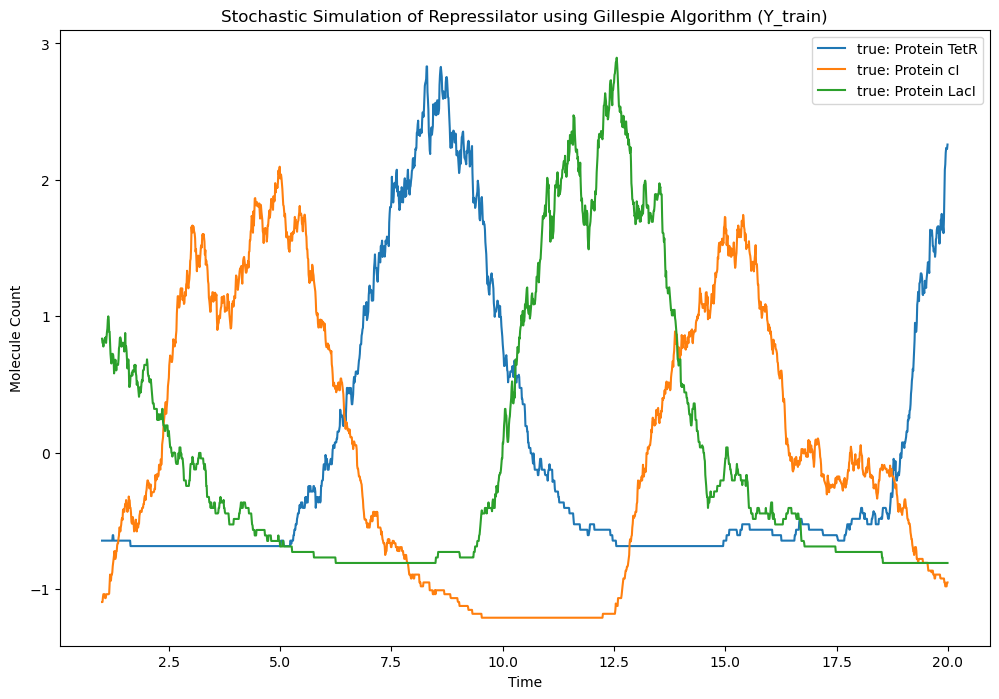

In [49]:
## you can plot it and get the data for a certain time interval
X_train, Y_train, times = dataset(20, 100)

predicted_mRNA_TetR = X_train[0, :]
print(predicted_mRNA_TetR)
predicted_protein_TetR = X_train[1, :]
predicted_mRNA_cI = X_train[2, :]
predicted_protein_cI = X_train[3, :]
predicted_mRNA_LacI = X_train[4, :]
predicted_protein_LacI = X_train[5, :]

#true values
true_mRNA_TetR = Y_train[0, :]
true_protein_TetR = Y_train[1, :]
true_mRNA_cI = Y_train[2, :]
true_protein_cI = Y_train[3, :]
true_mRNA_LacI = Y_train[4, :]
true_protein_LacI = Y_train[5, :]

# Plot the results
plt.figure(figsize=(12, 8))

plt.plot(times, true_protein_TetR, label='true: Protein TetR')
plt.plot(times, true_protein_cI, label='true: Protein cI')
plt.plot(times, true_protein_LacI, label='true: Protein LacI')
plt.xlabel('Time')
plt.ylabel('Molecule Count')
plt.legend()
plt.title('Stochastic Simulation of Repressilator using Gillespie Algorithm (Y_train)')
plt.show()
## This one should be "Ahead" of the X_train graph

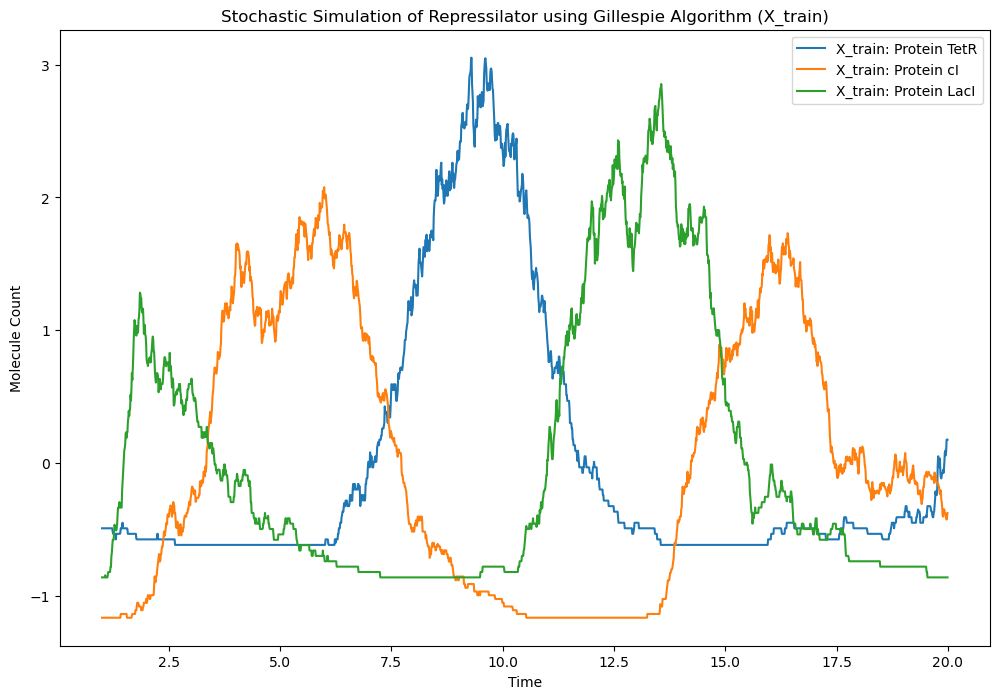

In [50]:
plt.figure(figsize=(12, 8))

plt.plot(times, predicted_protein_TetR, label='X_train: Protein TetR')
plt.plot(times, predicted_protein_cI, label='X_train: Protein cI')
plt.plot(times, predicted_protein_LacI, label='X_train: Protein LacI')
plt.xlabel('Time')
plt.ylabel('Molecule Count')
plt.legend()
plt.title('Stochastic Simulation of Repressilator using Gillespie Algorithm (X_train)')
plt.show()

In [ ]:
# Making a pandas Datafram so that the data is more malleable and then exporting it as a csv file.

predicted_mRNA_TetR = X_train[0, :]
#print(predicted_mRNA_TetR)
predicted_protein_TetR = X_train[1, :]
predicted_mRNA_cI = X_train[2, :]
predicted_protein_cI = X_train[3, :]
predicted_mRNA_LacI = X_train[4, :]
predicted_protein_LacI = X_train[5, :]


#true values
true_mRNA_TetR = Y_train[0, :]
true_protein_TetR = Y_train[1, :]
true_mRNA_cI = Y_train[2, :]
true_protein_cI = Y_train[3, :]
true_mRNA_LacI = Y_train[4, :]
true_protein_LacI = Y_train[5, :]

dict = { "Times" : times, "X_mRNA_TetR" : predicted_mRNA_TetR, "X_protein_TetR" : predicted_protein_TetR, "X_mRNA_cI" : predicted_mRNA_cI,
        "X_protein_cI" : predicted_protein_cI, "X_mRNA_LacI" : predicted_mRNA_LacI, "X_protein_LacI" : predicted_protein_LacI,
        "Y_mRNA_TetR" : true_mRNA_TetR, "Y_protein_TetR" : true_protein_TetR, "Y_mRNA_cI" : true_mRNA_cI,
        "Y_protein_cI" : true_protein_cI, "Y_mRNA_LacI" : true_mRNA_LacI, "Y_protein_LacI" : true_protein_LacI}

df = pd.DataFrame(dict)

In [ ]:
df.to_csv("file1.csv")